# Quickstart

This notebook shows how to train and validate a model with ScAPE and how to do predictions for cell/drug combinations

In [1]:
# Disable all warnings
import scape
import pandas as pd

scape.__version__

'0.1.1'

In [2]:
df_de = scape.io.load_slogpvals("../../_data/de_train.parquet")
df_lfc = scape.io.load_lfc("../../_data/lfc_train.parquet")

# Make sure rows/columns are in the same order
df_lfc = df_lfc.loc[df_de.index, df_de.columns]
df_de.shape, df_lfc.shape

((614, 18211), (614, 18211))

In [3]:
# We select only a subset of the genes for the model (top most variant genes)
n_genes = 64
top_genes = scape.util.select_top_variable([df_de], k=n_genes)

# Data sources point to the dataframes with the data from which the features are extracted
data_sources = {
    'slogpval': df_de,
    'lfc_pseudo': df_lfc
}

# Define the way in which the features are extracted from the data sources
feature_extraction = {
    'slogpval_drug': {
        'source': 'slogpval',
        'groupby': 'sm_name',
        'function': 'median'
    },
    'lfc_drug': {
        'source': 'lfc_pseudo',
        'groupby': 'sm_name',
        'function': 'median'
    },
    'slogpval_cell': {
        'source': 'slogpval',
        'groupby': 'cell_type',
        'function': 'median'
    },
    'lfc_cell': {
        'source': 'lfc_pseudo',
        'groupby': 'cell_type',
        'function': 'median'
    }
}

# Names of the input layers -> feature extraction method
input_mapping = {
    'in_slogpval_drug': 'slogpval_drug',
    'in_lfc_drug': 'lfc_drug',
    'in_slogpval_cell_encoder': 'slogpval_cell',
    'in_lfc_cell_encoder': 'lfc_cell',
    'in_slogpval_cell_decoder': 'slogpval_cell',
    'in_lfc_cell_decoder': 'lfc_cell',
}

# Configuration for the NN architecture
config = {
    "inputs": {
        "in_slogpval_drug"          : [n_genes, 256, 128],
        "in_lfc_drug"               : [n_genes, 256, 128],
    },
    "conditional_encoder_input_structure": {
        "in_slogpval_cell_encoder"  : [n_genes, 32],
        "in_lfc_cell_encoder"       : [n_genes, 32, 16],
    },
    "conditional_decoder_input_structure": {
        "in_slogpval_cell_decoder"  : [n_genes, 32],
        "in_lfc_cell_decoder"       : [n_genes, 32, 16],
    },
    "conditional_decoder_input_hidden_sizes": [32],
    "encoder_hidden_layer_sizes": [128, 128],
    "decoder_hidden_layer_sizes": [128, 512],
    "outputs": {
        "logpval": (df_de.shape[1], "linear"), 
    },
    # Layer config
    "noise": 0.01,
    "dropout": 0.05,
    "l1": 0,
    "l2": 0
}

model_setup = {
    "data_sources": data_sources,
    "feature_extraction": feature_extraction,
    "input_mapping": input_mapping,
    "output_genes": df_de.columns,
    "config": config
}

# Create model
scm = scape.SCAPE(model_setup)
scape.util.plot(scm.model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [4]:
scm.model.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ in_slogpval_drug    │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_lfc_drug         │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_slogpval_cell_e… │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_lfc_cell_encoder │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 128)       │    198,288 │ in_slogpval_drug… │
│ (Functional)        │                   │            │ in_lfc_drug[0][0… │
│                     │                   │            │ in_slogpval_cell… │
│                     │                   │            │ in_lfc_cell_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_slogpval_cell_d… │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ in_lfc_cell_decoder │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 18211)     │  9,439,187 │ encoder[0][0],    │
│ (Functional)        │                   │            │ in_slogpval_cell… │
│                     │                   │            │ in_lfc_cell_deco… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,637,475 (36.76 MB)

 Trainable params: 9,632,483 (36.75 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [5]:
result = scm.train(
    val_cells=["NK cells"], 
    val_drugs=["Prednisolone"],
    input_columns=top_genes,
    epochs=300,
    baselines=["zero", "slogpval_drug"]
)

Baseline zero MRRMSE: 1.4273
Baseline slogpval_drug MRRMSE: 1.1278
Model size (MB): 36.76
Model inputs: ['in_slogpval_drug', 'in_lfc_drug', 'in_slogpval_cell_encoder', 'in_lfc_cell_encoder', 'in_slogpval_cell_decoder', 'in_lfc_cell_decoder']
Epoch    1: val_loss None -> 1.4176, train loss: 1.3074 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0068, 0.68%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.7955, -25.70%
Epoch    2: val_loss 1.4176 -> 1.3751, train loss: 1.2784 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0379, 3.65%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8201, -21.93%
Epoch    3: val_loss 1.3751 -> 1.3533, train loss: 1.2508 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0547, 5.18%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8334, -20.00%
Epoch    4: val_loss 1.3533 -> 1.3502, trai

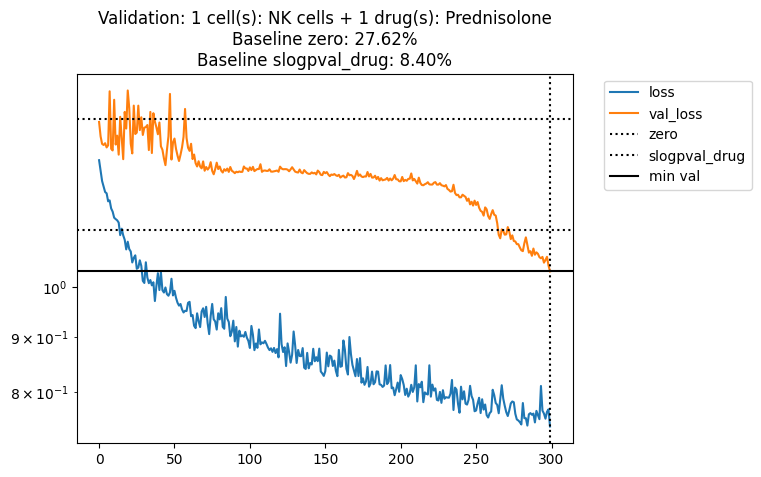

In [6]:
scape.util.plot_result(result, legend=True)

## Inference

In [7]:
# Predict using a given dataframe index
scm.predict(df_de)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


,,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
cell_type,sm_name,,,,,,,,,,,,,,,,,,,,,
NK cells,Clotrimazole,0.197786,0.126039,-0.104177,-0.039571,0.248180,0.524444,0.081580,0.177209,-0.148725,0.153519,...,0.142030,-0.165291,-0.035104,0.057520,0.040788,0.042308,0.159126,0.049449,0.006970,-0.034757
T cells CD4+,Clotrimazole,0.050871,-0.075059,0.084434,-0.174816,-0.026971,0.298652,-0.113377,0.147880,0.025892,0.168293,...,-0.191463,0.114608,0.047810,0.006253,0.337465,0.036695,0.234515,0.049516,0.197154,-0.105765
T cells CD8+,Clotrimazole,-0.175688,-0.475267,-0.209831,-0.086159,-0.150552,-0.338917,-0.139434,-0.175639,-0.370091,0.213963,...,0.044183,-0.375991,-0.377197,-0.450851,-0.041305,-0.318333,0.070286,-0.144888,-0.102335,-0.202436
T regulatory cells,Clotrimazole,0.394469,0.293319,0.581215,0.718463,0.751428,0.657374,-0.071773,0.326694,-0.162748,0.118148,...,-0.015783,0.438125,0.089959,0.260447,0.496685,0.545174,0.442335,0.262748,-0.133469,-0.011818
NK cells,Mometasone Furoate,1.112128,-0.237730,-0.504447,-0.123416,0.418966,1.627063,0.525786,1.276731,0.091404,2.030003,...,-0.198958,-0.400687,0.253600,-0.001567,-0.053851,0.501146,0.625572,0.951136,-1.329853,0.748140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T regulatory cells,Atorvastatin,0.157081,-0.186908,-0.253292,-0.338174,-0.156692,-0.209362,-0.014297,-0.818362,-0.155121,-0.101975,...,-0.395198,-0.599169,-0.313211,-0.563991,-0.327206,0.168903,-0.337552,-0.208302,-0.026495,-0.522464
NK cells,Riociguat,0.051361,0.197749,-0.083265,-0.096102,0.120137,0.248692,0.064973,0.192985,-0.154495,0.068541,...,0.138683,-0.075217,-0.170390,0.058682,-0.027309,0.018612,0.107430,0.042584,0.020584,-0.109636
T cells CD4+,Riociguat,0.054133,-0.046197,0.034630,-0.241379,-0.087980,0.075699,-0.067188,0.125653,0.050373,0.029637,...,-0.096360,0.096111,-0.096438,0.117287,0.336917,0.073524,0.184389,-0.032350,0.227817,-0.111530


In [8]:
# Predict from a given multi-index
scm.predict(
    pd.MultiIndex.from_tuples([
        ("NK cells", "Bosutinib"),
        ("NK cells", "Belinostat"),
        ("Myeloid cells", "Bosutinib"),
        ("Myeloid cells", "Belinostat"),
    ], names=["cell_type", "sm_name"])
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


A1BG  A1BG-AS1        A2M    A2M-AS1      A2MP1  \
cell_type     sm_name                                                           
NK cells      Bosutinib   0.369894  0.114098  -0.083083   0.030737   0.358507   
              Belinostat  4.280519  6.467023 -12.697368 -20.889540  -4.970930   
Myeloid cells Bosutinib   0.790377  0.249923  -0.135318   0.576701   4.574362   
              Belinostat  5.239907  4.489112 -16.674381  -1.714378  23.530394   

                             A4GALT      AAAS      AACS     AAGAB      AAK1  \
cell_type     sm_name                                                         
NK cells      Bosutinib    0.862541  0.138142  0.292810 -0.132139  0.352971   
              Belinostat  13.574057  1.377557  1.617468  7.399392  7.623521   
Myeloid cells Bosutinib    2.335531  0.091372  0.220384  0.015109  0.441978   
              Belinostat  10.060462 -0.133385 -2.172630  3.644561  7.830135   

                          ...      ZUP1      ZW10     ZWILCH     ZWINT  \
cell_type     sm_name     ...                                            
NK cells      Bosutinib   ...  0.154839 -0.227453   0.118985  0.068057   
              Belinostat  ...  8.428455  3.415626  -4.388937  2.179397   
Myeloid cells Bosutinib   ... -0.938971 -0.733338  -0.198901 -0.975052   
              Belinostat  ...  4.573981  1.599512 -11.761007 -1.309972   

                              ZXDA      ZXDB      ZXDC    ZYG11B       ZYX  \
cell_type     sm_name                                                        
NK cells      Bosutinib   0.092128  0.118599  0.246167  0.129017 -0.047203   
              Belinostat -2.303617  0.808985 -1.321960  6.605582  0.832844   
Myeloid cells Bosutinib   1.143269  0.174065 -0.205027  0.073627 -0.180281   
              Belinostat  2.631190 -1.830501 -5.093564  1.191484  4.558982   

                             ZZEF1  
cell_type     sm_name               
NK cells      Bosutinib   0.048021  
              Belinostat -2.503772  
Myeloid cells Bosutinib  -0.007635  
              Belinostat -1.436727  

[4 rows x 18211 columns]

In [9]:
# Predict from tuples
scm.predict([("NK cells", "Bosutinib"), ("NK cells", "Belinostat")])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


A1BG  A1BG-AS1        A2M    A2M-AS1     A2MP1  \
cell_type sm_name                                                          
NK cells  Bosutinib   0.369894  0.114098  -0.083083   0.030737  0.358506   
          Belinostat  4.280519  6.467022 -12.697369 -20.889540 -4.970931   

                         A4GALT      AAAS      AACS     AAGAB      AAK1  ...  \
cell_type sm_name                                                        ...   
NK cells  Bosutinib    0.862541  0.138142  0.292810 -0.132139  0.352971  ...   
          Belinostat  13.574056  1.377558  1.617468  7.399390  7.623520  ...   

                          ZUP1      ZW10    ZWILCH     ZWINT      ZXDA  \
cell_type sm_name                                                        
NK cells  Bosutinib   0.154839 -0.227453  0.118985  0.068057  0.092128   
          Belinostat  8.428456  3.415626 -4.388936  2.179397 -2.303617   

                          ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1  
cell_type sm_name                                                       
NK cells  Bosutinib   0.118599  0.246167  0.129017 -0.047203  0.048021  
          Belinostat  0.808985 -1.321960  6.605581  0.832843 -2.503771  

[2 rows x 18211 columns]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


<Axes: xlabel='y', ylabel='y_pred'>

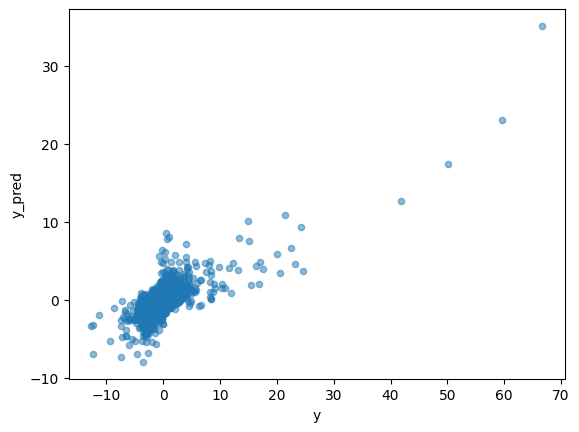

In [10]:
# Plot correlation between predicted and observed values
df_cmp = pd.DataFrame({
    'y': df_de.loc[("NK cells", "Prednisolone")].values.ravel(), 
    'y_pred': scm.predict([("NK cells", "Prednisolone")]).values.ravel()
})

# Make the plot square with same X and Y limits
df_cmp.plot.scatter(x='y', y='y_pred', alpha=0.5)

In [11]:
# Save model
scm.save("../../_models/config.pkl", "../../_models/model.weights.h5", "../../_models/result.pkl")

In [12]:
scm = scape.SCAPE.load("../../_models/config.pkl", "../../_models/model.weights.h5", "../../_models/result.pkl")
scm.predict([("NK cells", "Bosutinib"), ("NK cells", "Belinostat")])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


A1BG  A1BG-AS1        A2M    A2M-AS1     A2MP1  \
cell_type sm_name                                                          
NK cells  Bosutinib   0.369894  0.114098  -0.083083   0.030737  0.358506   
          Belinostat  4.280519  6.467022 -12.697369 -20.889540 -4.970931   

                         A4GALT      AAAS      AACS     AAGAB      AAK1  ...  \
cell_type sm_name                                                        ...   
NK cells  Bosutinib    0.862541  0.138142  0.292810 -0.132139  0.352971  ...   
          Belinostat  13.574056  1.377558  1.617468  7.399390  7.623520  ...   

                          ZUP1      ZW10    ZWILCH     ZWINT      ZXDA  \
cell_type sm_name                                                        
NK cells  Bosutinib   0.154839 -0.227453  0.118985  0.068057  0.092128   
          Belinostat  8.428456  3.415626 -4.388936  2.179397 -2.303617   

                          ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1  
cell_type sm_name                                                       
NK cells  Bosutinib   0.118599  0.246167  0.129017 -0.047203  0.048021  
          Belinostat  0.808985 -1.321960  6.605581  0.832843 -2.503771  

[2 rows x 18211 columns]

## Save during training

In [13]:
scm = scape.SCAPE(model_setup)

result = scm.train(
    val_cells=["NK cells"], 
    val_drugs=["Prednisolone"],
    input_columns=top_genes,
    epochs=30,
    baselines=["zero", "slogpval_drug"],
    output_folder="../../_models",
    config_file_name="example_config.pkl",
    model_file_name=f"example_model.keras",
    result_file_name="example_result.pkl"
)

Baseline zero MRRMSE: 1.4273
Baseline slogpval_drug MRRMSE: 1.1278
Model size (MB): 36.76
Model inputs: ['in_slogpval_drug', 'in_lfc_drug', 'in_slogpval_cell_encoder', 'in_lfc_cell_encoder', 'in_slogpval_cell_decoder', 'in_lfc_cell_decoder']
Model will be saved to ../../_models/example_model.keras
Epoch    1: val_loss None -> 1.4207, train loss: 1.3074 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0046, 0.46%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.7938, -25.98%
Epoch    2: val_loss 1.4207 -> 1.3840, train loss: 1.2799 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0313, 3.03%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8149, -22.72%
Epoch    3: val_loss 1.3840 -> 1.3491, train loss: 1.2530 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0579, 5.48%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.

In [14]:
# Check that the error is the same
scm = scape.model.SCAPE.load( "_models/example_config.pkl", "_models/example_model.weights.h5", "_models/example_result.pkl")

y_true = df_de.loc[(df_de.index.get_level_values("cell_type") == "NK cells") & (df_de.index.get_level_values("sm_name") == "Prednisolone")]
y_pred = scm.predict([("NK cells", "Prednisolone")])

scape.losses.np_mrrmse(y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


np.float64(1.3170591261709397)